# Imports

In [ ]:
import torch
from torch.utils.data import Subset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.func import functional_call
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import json
import copy
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from abc import ABC, abstractmethod

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)

# Global Variables

In [ ]:
load_100 = False
num_classes = 100 if load_100 else 10
batch_size = 64
num_epochs = 50

# Data

In [ ]:
if load_100:
    transform_initial = transforms.Compose([
        transforms.ToTensor()
    ])
    trainset_full = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_initial)
    testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_initial)
else:
    transform_initial = transforms.Compose([
        transforms.ToTensor()
    ])
    trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_initial)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_initial)
    # mean: tensor([0.4918, 0.4825, 0.4469])
    # std: tensor([0.2469, 0.2435, 0.2616])
# step 1: split data into train and validation indices
train_indices = list(range(len(trainset_full)))
train_labels = trainset_full.targets
train_idx, val_idx = train_test_split(train_indices, test_size=0.2, stratify=train_labels, random_state=0)
# step 2: create train and validation subsets
train_subset = Subset(trainset_full, train_idx)
val_subset = Subset(trainset_full, val_idx)
# step 3: compute mean and standard deviation on the train set
trainloader_temp = torch.utils.data.DataLoader(train_subset, batch_size=len(train_subset), shuffle=False)
data = next(iter(trainloader_temp))
mean = data[0].mean([0, 2, 3])
std = data[0].std([0, 2, 3])
print(mean)
print(std)

100%|██████████| 170M/170M [00:04<00:00, 42.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
tensor([0.4918, 0.4825, 0.4469])
tensor([0.2469, 0.2435, 0.2616])


In [ ]:
# step 4: define transformations for train, validation, and test sets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
# step 5: apply transformations to the respective datasets
trainset_full.transform = transform_train
val_subset.dataset.transform = transform_test
testset.transform = transform_test
# step 6: define data loaders for train, validation, and test sets
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
validationloader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# Optimizers

## SGDW

In [ ]:
class SGDW(optim.SGD):
    def __init__(self, params, lr=0.01, momentum=0, dampening=0, weight_decay=0.01, nesterov=False):
        super(SGDW, self).__init__(params, lr=lr, momentum=momentum, dampening=dampening, weight_decay=0, nesterov=nesterov)
        self.weight_decay = weight_decay

    def step(self, closure=None):
        # apply weight decay to parameters before gradient step
        for group in self.param_groups:
            for param in group['params']:
                if param.grad is None:
                    continue
                param.data.add_(param.data, alpha=-self.weight_decay * group['lr'])
        # apply step
        super(SGDW, self).step(closure)


## Custom Optimizer

In [ ]:
class Optimizer:
    """
    Defines optimizer, optimizer function and learning rate scheduler.
    """
    def __init__(
        self, model, optimizer_type, lr,
        weight_decay, momentum=0.9, rho=0.9, epsilon=1e-8,
        lr_scheduler_factor=0.7, lr_scheduler_patience=3
    ):
        self.model = model
        self.lr = lr
        self.weight_decay = weight_decay
        self.momentum = momentum
        self.rho = rho
        self.epsilon = epsilon
        self.optimizer_type = optimizer_type
        self.lr_scheduler_factor = lr_scheduler_factor
        self.lr_scheduler_patience = lr_scheduler_patience
        self.optimizer, self.optimizer_function, self.lr_scheduler = self._initialize_optimizer(self.optimizer_type)

    def _initialize_optimizer(self, optimizer_type):
        """Initializes optimizer and corresponding gradient function based on optimizer type."""
        if optimizer_type == "sgd":
            optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
            optimizer_function = self.sgd_momentum_gradients
        elif optimizer_type == "sgdw":
            optimizer = SGDW(self.model.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
            optimizer_function = self.sgdw_momentum_gradients
        elif optimizer_type == "adam":
            optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
            optimizer_function = self.adam_gradients
        elif optimizer_type == "adamw":
            optimizer = optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
            optimizer_function = self.adamw_gradients
        elif optimizer_type == "rmsprop":
            optimizer = optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=self.rho, eps=self.epsilon)
            optimizer_function = self.rmsprop_gradients
        else:
            raise ValueError(f"Optimizer type '{optimizer_type}' is not supported.")
        lr_scheduler = self._initialize_lr_scheduler(optimizer)
        return optimizer, optimizer_function, lr_scheduler

    def _initialize_lr_scheduler(self, optimizer):
        """Initializes learning rate scheduler based on the optimizer."""
        lr_scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=self.lr_scheduler_factor, patience=self.lr_scheduler_patience)
        return lr_scheduler

    def adagrad_gradients(self):
        optimizer_gradients = []
        for param in self.model.parameters():
            if param.grad is not None:
                # initialize accumulated sum of squared gradients if not present
                if "sum_sq_grads" not in self.optimizer.state[param]:
                    self.optimizer.state[param]["sum_sq_grads"] = torch.zeros_like(param.grad)
                # retrieve the accumulated squared gradients
                sum_sq_grads = self.optimizer.state[param]["sum_sq_grads"]
                # accumulate the squared gradients
                sum_sq_grads.addcmul_(param.grad, param.grad)  # G_t = G_{t-1} + g_t^2
                # compute AdaGrad-adjusted gradient
                adagrad_adjusted_grad = param.grad / (sum_sq_grads.sqrt() + self.epsilon)
                # append the adjusted gradient (with learning rate scaling)
                optimizer_gradients.append(adagrad_adjusted_grad.clone())
        return optimizer_gradients

    def rmsprop_gradients(self):
        optimizer_gradients = []
        for param in self.model.parameters():
            if param.grad is not None:
                # initialize the moving average of squared gradients if not present
                if "square_avg" not in self.optimizer.state[param]:
                    self.optimizer.state[param]["square_avg"] = torch.zeros_like(param.grad)
                # retrieve the moving average of squared gradients and lr
                square_avg = self.optimizer.state[param]["square_avg"]
                lr = self.optimizer.defaults["lr"]
                # update the moving average of squared gradients
                square_avg.mul_(self.rho).addcmul_(param.grad, param.grad, value=(1 - self.rho))
                # compute RMSprop-adjusted gradient
                rmsprop_adjusted_grad = lr * param.grad / (square_avg.sqrt() + self.epsilon)
                # append the adjusted gradient with learning rate scaling
                optimizer_gradients.append(rmsprop_adjusted_grad.clone())
        return optimizer_gradients

    def sgd_momentum_gradients(self):
        optimizer_gradients = []
        for param in self.model.parameters():
            if param.grad is not None:
                # l2 regularization
                weight_decay = self.optimizer.defaults["weight_decay"]
                param.grad = param.grad + weight_decay * param.data
                # initialize velocity in optimizer state if not already present
                if "velocity" not in self.optimizer.state[param]:
                    self.optimizer.state[param]["velocity"] = torch.zeros_like(param.grad)
                # retrieve the current velocity factor
                velocity = self.optimizer.state[param]["velocity"]
                lr = self.optimizer.defaults["lr"]
                # update the velocity
                velocity.mul_(self.momentum).add_(param.grad, alpha=lr)  # v_t = gamma * v_{t-1} + eta * g_t
                # append the updated velocity (momentum-adjusted gradient)
                optimizer_gradients.append(velocity.clone())  # clone to avoid in-place modifications
        return optimizer_gradients

    def sgdw_momentum_gradients(self):
        optimizer_gradients = []
        for param in self.model.parameters():
            if param.grad is not None:
                # initialize velocity in optimizer state if not already present
                if "velocity" not in self.optimizer.state[param]:
                    self.optimizer.state[param]["velocity"] = torch.zeros_like(param.grad)
                # retrieve current velocity and momentum factor
                velocity = self.optimizer.state[param]["velocity"]
                lr = self.optimizer.defaults["lr"]
                weight_decay = self.optimizer.defaults["weight_decay"]
                # update the velocity with momentum and learning rate
                velocity.mul_(self.momentum).add_(param.grad, alpha=lr)  # v_t = gamma * v_{t-1} + eta * g_t
                # apply decoupled weight decay
                optimizer_grad = velocity + weight_decay * param.data
                # append the updated velocity (momentum-adjusted gradient)
                optimizer_gradients.append(optimizer_grad.clone())  # clone to avoid in-place modifications
        return optimizer_gradients

    def adam_gradients(self):
        optimizer_gradients = []
        for param in self.model.parameters():
            if param.grad is not None:
                # l2 regularization
                weight_decay = self.optimizer.defaults["weight_decay"]
                param.grad = param.grad + weight_decay * param.data
                # initialize exp_avg, exp_avg_sq, and step in optimizer state if not already done
                if "exp_avg" not in self.optimizer.state[param]:
                    self.optimizer.state[param]["exp_avg"] = torch.zeros_like(param.grad)
                if "exp_avg_sq" not in self.optimizer.state[param]:
                    self.optimizer.state[param]["exp_avg_sq"] = torch.zeros_like(param.grad)
                if "step" not in self.optimizer.state[param]:
                    self.optimizer.state[param]["step"] = 0
                # retrieve optimizer state variables
                exp_avg = self.optimizer.state[param]["exp_avg"]
                exp_avg_sq = self.optimizer.state[param]["exp_avg_sq"]
                step = self.optimizer.state[param]["step"]
                beta1, beta2 = self.optimizer.defaults["betas"]
                eps = self.optimizer.defaults["eps"]
                lr = self.optimizer.defaults["lr"]
                # increment step count
                step += 1
                self.optimizer.state[param]["step"] = step
                # update exp_avg and exp_avg_sq according to Adam rules
                exp_avg.mul_(beta1).add_(param.grad, alpha=(1 - beta1))  # update first moment
                exp_avg_sq.mul_(beta2).addcmul_(param.grad, param.grad, value=(1 - beta2))  # update second moment
                # compute bias-corrected first and second moments
                exp_avg_corrected = exp_avg / (1 - beta1 ** step)
                exp_avg_sq_corrected = exp_avg_sq / (1 - beta2 ** step)
                # calculate the optimizer-adjusted gradient
                optimizer_grad = lr * exp_avg_corrected / (exp_avg_sq_corrected.sqrt() + eps)
                optimizer_gradients.append(optimizer_grad.clone())  # clone to avoid in-place modifications
        return optimizer_gradients

    def adamw_gradients(self):
        optimizer_gradients = []
        for param in self.model.parameters():
            if param.grad is not None:
                # initialize exp_avg, exp_avg_sq, and step in optimizer state if not already done
                if "exp_avg" not in self.optimizer.state[param]:
                    self.optimizer.state[param]["exp_avg"] = torch.zeros_like(param.grad)
                if "exp_avg_sq" not in self.optimizer.state[param]:
                    self.optimizer.state[param]["exp_avg_sq"] = torch.zeros_like(param.grad)
                if "step" not in self.optimizer.state[param]:
                    self.optimizer.state[param]["step"] = 0
                # retrieve optimizer state variables
                exp_avg = self.optimizer.state[param]["exp_avg"]
                exp_avg_sq = self.optimizer.state[param]["exp_avg_sq"]
                step = self.optimizer.state[param]["step"]
                beta1, beta2 = self.optimizer.defaults["betas"]
                eps = self.optimizer.defaults["eps"]
                lr = self.optimizer.defaults["lr"]
                weight_decay = self.optimizer.defaults["weight_decay"]
                # increment step count
                step += 1
                self.optimizer.state[param]["step"] = step
                # update exp_avg and exp_avg_sq according to Adam rules
                exp_avg.mul_(beta1).add_(param.grad, alpha=(1 - beta1))  # first moment update
                exp_avg_sq.mul_(beta2).addcmul_(param.grad, param.grad, value=(1 - beta2))  # second moment update
                # compute bias-corrected first and second moments
                exp_avg_corrected = exp_avg / (1 - beta1 ** step)
                exp_avg_sq_corrected = exp_avg_sq / (1 - beta2 ** step)
                # calculate optimizer-adjusted gradient
                adam_adjusted_grad = lr * exp_avg_corrected / (exp_avg_sq_corrected.sqrt() + eps)
                # apply weight decay
                param.data.mul_(1 - lr * weight_decay)
                optimizer_grad = adam_adjusted_grad + weight_decay * param.data
                # apply decoupled weight decay to the parameters
                optimizer_gradients.append(optimizer_grad.clone())  # clone to avoid in-place modifications
        return optimizer_gradients

    def update_params(self, optimizer_gradients):
        with torch.no_grad():
            for param, optimizer_grad in zip(self.model.parameters(), optimizer_gradients):
                param -= optimizer_grad

## Meta Optimizer

In [ ]:
class MetaNNsOptimizer:
    """
    Defines optimizer, optimizer function and learning rate scheduler.
    """
    def __init__(
        self, models, optimizer_type, lr,
        weight_decay, momentum=0.9, rho=0.9, epsilon=1e-8,
        lr_scheduler_factor=0.7, lr_scheduler_patience=3
    ):
        self.params = [param for model in models for param in model.parameters()]
        self.lr = lr
        self.weight_decay = weight_decay
        self.momentum = momentum
        self.rho = rho
        self.epsilon = epsilon
        self.optimizer_type = optimizer_type
        self.lr_scheduler_factor = lr_scheduler_factor
        self.lr_scheduler_patience = lr_scheduler_patience
        self.optimizer, self.lr_scheduler = self._initialize_optimizer(self.optimizer_type)

    def _initialize_optimizer(self, optimizer_type):
        """Initializes optimizer and corresponding gradient function based on optimizer type."""
        if optimizer_type == "sgd":
            optimizer = optim.SGD(self.params, lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
        elif optimizer_type == "sgdw":
            optimizer = SGDW(self.params, lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
        elif optimizer_type == "adam":
            optimizer = optim.Adam(self.params, lr=self.lr, weight_decay=self.weight_decay)
        elif optimizer_type == "adamw":
            optimizer = optim.AdamW(self.params, lr=self.lr, weight_decay=self.weight_decay)
        elif optimizer_type == "rmsprop":
            optimizer = optim.RMSprop(self.params, lr=self.lr, alpha=self.rho, eps=self.epsilon)
        else:
            raise ValueError(f"Optimizer type '{optimizer_type}' is not supported.")
        lr_scheduler = self._initialize_lr_scheduler(optimizer)
        return optimizer, lr_scheduler

    def _initialize_lr_scheduler(self, optimizer):
        """Initializes learning rate scheduler based on the optimizer."""
        lr_scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=self.lr_scheduler_factor, patience=self.lr_scheduler_patience)
        return lr_scheduler

class MetaOptimizer:
    """
    Defines optimizer, optimizer function and learning rate scheduler.
    """
    def __init__(
        self, model, optimizer_type, lr,
        weight_decay, momentum=0.9, rho=0.9, epsilon=1e-8,
        lr_scheduler_factor=0.7, lr_scheduler_patience=3
    ):
        self.model = model
        self.lr = lr
        self.weight_decay = weight_decay
        self.momentum = momentum
        self.rho = rho
        self.epsilon = epsilon
        self.optimizer_type = optimizer_type
        self.lr_scheduler_factor = lr_scheduler_factor
        self.lr_scheduler_patience = lr_scheduler_patience
        self.optimizer, self.lr_scheduler = self._initialize_optimizer(self.optimizer_type)

    def _initialize_optimizer(self, optimizer_type):
        """Initializes optimizer and corresponding gradient function based on optimizer type."""
        if optimizer_type == "sgd":
            optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
        elif optimizer_type == "sgdw":
            optimizer = SGDW(self.model.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
        elif optimizer_type == "adam":
            optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        elif optimizer_type == "adamw":
            optimizer = optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        elif optimizer_type == "rmsprop":
            optimizer = optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=self.rho, eps=self.epsilon)
        else:
            raise ValueError(f"Optimizer type '{optimizer_type}' is not supported.")
        lr_scheduler = self._initialize_lr_scheduler(optimizer)
        return optimizer, lr_scheduler

    def _initialize_lr_scheduler(self, optimizer):
        """Initializes learning rate scheduler based on the optimizer."""
        lr_scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=self.lr_scheduler_factor, patience=self.lr_scheduler_patience)
        return lr_scheduler

# Main Networks

## VGG

In [ ]:
class VGG(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG, self).__init__()
        # input_shape: (batch_size,num_channels,image_width,image_height)
        #              (batch_size,3,32,32)
        # conv block 1
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1) # output shape: (batch_size,64,32,32), weights: (64,3,3,3), bias: (64)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1) # output shape: (batch_size,64,32,32), weights: (64,64,3,3), bias: (64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # output shape: (batch_size,64,16,16)
        # conv block 2
        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # output shape: (batch_size,128,16,16), weights: (128,64,3,3), bias: (128)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1) # output shape: (batch_size,128,16,16), weights: (128,128,3,3), bias: (128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # output shape: (batch_size,128,8,8)
        # conv block 3
        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1) # output shape: (batch_size, 256, 8, 8), weights: (256,128,3,3), bias: (256)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1) # output shape: (batch_size, 256, 8, 8), weights: (256,256,3,3), bias: (256)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1) # output shape: (batch_size, 256, 8, 8), weights: (256,256,3,3), bias: (256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # output shape: (batch_size,256,4,4)
        # conv block 4
        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1) # output shape: (batch_size, 512, 4, 4), weights: (512,256,3,3), bias: (512)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1) # output shape: (batch_size, 512, 4, 4), weights: (512,512,3,3), bias: (512)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1) # output shape: (batch_size, 512, 4, 4), weights: (512,512,3,3), bias: (512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # output shape: (batch_size,512,2,2)
        # fc 1
        self.fc1 = nn.Linear(in_features=512*2*2, out_features=512) # output shape: (batch_size, 512), weights: (2048,512), bias: (512)
        # fc 2
        self.fc2 = nn.Linear(in_features=512, out_features=512) # output shape: (batch_size, 512), weights: (512,512), bias: (512)
        # fc 3
        self.fc3 = nn.Linear(in_features=512, out_features=num_classes) # output shape: (batch_size, 10), weights: (512,10), bias: (10)

    def forward(self, x):
        # convs
        x = self.pool1(F.relu(self.conv1_2(F.relu(self.conv1_1(x)))))
        x = self.pool2(F.relu(self.conv2_2(F.relu(self.conv2_1(x)))))
        x = self.pool3(F.relu(self.conv3_3(F.relu(self.conv3_2(F.relu(self.conv3_1(x)))))))
        x = self.pool4(F.relu(self.conv4_3(F.relu(self.conv4_2(F.relu(self.conv4_1(x)))))))
        # flatten
        x = x.view(x.size(0), -1)
        # fcs
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.5)
        x = self.fc3(x)
        return x

## ResNet

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()

        self.backbone = models.resnet18(weights=None)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

# Training Functions

In [ ]:
def plot_metrics(epoch_times, training_losses, validation_losses, training_accuracies, validation_accuracies):
    clear_output(wait=True)
    plt.figure(figsize=(16, 10))
    cumulative_epoch_times = np.cumsum(epoch_times)
    metrics = [(training_losses, "Training Loss", "Loss"),
                (validation_losses, "Validation Loss", "Loss"),
                (training_accuracies, "Training Accuracy", "Accuracy"),
                (validation_accuracies, "Validation Accuracy", "Accuracy"),
                (cumulative_epoch_times, "Total Runtime", "Total Time (seconds)")]
    colors = ["b", "orange", "g", "purple", "r"]
    for i, (data, title, ylabel) in enumerate(metrics, 1):
        plt.subplot(3, 2, i)
        plt.plot(range(1, len(data) + 1), data, marker="o", linestyle="-", color=colors[i - 1])
        plt.title(title)
        plt.xlabel("Epoch")
        plt.ylabel(ylabel)
        plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_results(optimizers_params, training_losses, validation_losses, training_accuracies, validation_accuracies, epoch_times):
    cumulative_epoch_times = [np.cumsum(times) for times in epoch_times]
    data = [training_losses, validation_losses, training_accuracies, validation_accuracies, cumulative_epoch_times]

    fig, axs = plt.subplots(3, 2, figsize=(16, 10))
    colors = ["blue", "green", "red", "purple", "orange"]
    titles = ["Training Loss", "Validation Loss", "Training Accuracy", "Validation Accuracy", "Epoch Times"]
    y_labels = ["Loss", "Loss", "Accuracy", "Accuracy", "Time (s)"]
    for i in range(5):
        ax = axs[i // 2, i % 2]
        for j, optimizer_params in enumerate(optimizers_params):
            ax.plot(data[i][j], color=colors[j], label=optimizer_params["optimizer_type"])
        ax.set_title(titles[i])
        ax.set_xlabel("Epoch")
        ax.set_ylabel(y_labels[i])
        ax.legend()
    plt.tight_layout()
    plt.show()

def save_results(optimizers_params, training_losses, validation_losses, training_accuracies, validation_accuracies, epoch_times, trainer_type):
    data = {}
    for i, optimizer_params in enumerate(optimizers_params):
        optimizer_type = optimizer_params["optimizer_type"]
        data[optimizer_type] = {
            "training_losses": training_losses[i],
            "validation_losses": validation_losses[i],
            "training_accuracies": training_accuracies[i],
            "validation_accuracies": validation_accuracies[i],
            "epoch_times": epoch_times[i]
        }
    # save to JSON file
    file_path = f"{trainer_type}_optimizers_metrics.json"
    with open(file_path, "w") as json_file:
        json.dump(data, json_file, indent=4)
    print(f"Results saved to {file_path}")

def train_and_evaluate(optimizers_params, model_class, loss_fn, trainer_class, device, trainloader, validationloader, testloader, num_classes, num_epochs):
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []
    epoch_times = []
    for optimizer_params in optimizers_params:
        # initialize model, loss, and trainer
        print(f"Training with {optimizer_params['optimizer_type']}\n")
        model = model_class(num_classes=num_classes)
        optimizer = Optimizer(model=model, optimizer_type=optimizer_params["optimizer_type"], lr=optimizer_params["lr"], weight_decay=optimizer_params["weight_decay"])
        trainer = trainer_class(device, trainloader, validationloader, testloader, model, loss_fn, optimizer, num_epochs)
        # train model
        trainer.train()
        # collect metrics
        training_losses.append(trainer.training_losses)
        validation_losses.append(trainer.validation_losses)
        training_accuracies.append(trainer.training_accuracies)
        validation_accuracies.append(trainer.validation_accuracies)
        epoch_times.append(trainer.epoch_times)
        print(f"Finished training with {optimizer_params['optimizer_type']}!\n")
    # plot results
    plot_results(optimizers_params, training_losses, validation_losses, training_accuracies, validation_accuracies, epoch_times)
    # # save results
    # save_results(optimizers_params, training_losses, validation_losses, training_accuracies, validation_accuracies, epoch_times, trainer_class.__name__)


# Default

## Trainers

### Abstract

In [ ]:
class Trainer(ABC):
    def __init__(self, device, trainloader, validationloader, testloader, model, loss, optimizer, num_epochs,
                 check_early_stopping=False, early_stop_patience=5, early_stop_min_delta=0.001,
                 to_plot_metrics=False):
        self.device = device
        # data
        self.trainloader = trainloader
        self.validationloader = validationloader
        self.testloader = testloader
        # model, loss
        self.model = model.to(self.device)
        self.criterion = loss
        # optimizer, optimizer function and learning rate scheduler
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        # early stopping
        self.check_early_stopping = check_early_stopping
        self.best_loss = float("inf")
        self.early_stop_count = 0
        self.early_stop_patience = early_stop_patience
        self.early_stop_min_delta = early_stop_min_delta
        # metrics
        self.to_plot_metrics = to_plot_metrics
        self.training_losses = []
        self.training_accuracies = []
        self.validation_losses = []
        self.validation_accuracies = []
        self.epoch_times = []
        self.test_accuracy = 0

    @abstractmethod
    def optimizer_step(self, model):
        pass

    def train(self):
        for epoch in tqdm(range(self.num_epochs), desc="Training Progress", unit="epoch"):
            # training
            start_time = time.time()
            running_loss, correct, total = 0.0, 0, 0
            for images, labels in self.trainloader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                self.optimizer.optimizer.zero_grad()
                loss.backward()
                self.optimizer_step()  # calls the subclass-defined optimizer step
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
            epoch_loss = running_loss / len(self.trainloader)
            epoch_accuracy = 100 * correct / total
            epoch_duration = time.time() - start_time
            self.training_losses.append(epoch_loss)
            self.training_accuracies.append(epoch_accuracy)
            self.epoch_times.append(epoch_duration)
            # validation
            val_running_loss, val_correct, val_total = 0.0, 0, 0
            self.model.eval()
            with torch.no_grad():
                for val_images, val_labels in self.validationloader:
                    val_images, val_labels = val_images.to(self.device), val_labels.to(self.device)
                    val_outputs = self.model(val_images)
                    val_loss = self.criterion(val_outputs, val_labels)
                    val_running_loss += val_loss.item()
                    _, val_predicted = val_outputs.max(1)
                    val_total += val_labels.size(0)
                    val_correct += val_predicted.eq(val_labels).sum().item()
            val_epoch_loss = val_running_loss / len(self.validationloader)
            val_epoch_accuracy = 100 * val_correct / val_total
            self.validation_losses.append(val_epoch_loss)
            self.validation_accuracies.append(val_epoch_accuracy)
            # plot metrics
            if self.to_plot_metrics:
                plot_metrics(self.epoch_times, self.training_losses, self.validation_losses, self.training_accuracies, self.validation_accuracies)
            # adjust scheduler
            self.optimizer.lr_scheduler.step(val_epoch_loss)
            # early stopping
            if self.check_early_stopping:
                if val_epoch_loss < self.best_loss - self.early_stop_min_delta:
                    self.best_loss = val_epoch_loss
                    self.early_stop_count = 0
                else:
                    self.early_stop_count += 1
                    if self.early_stop_count >= self.early_stop_patience:
                        print("Early stopping triggered.")
                        break

    def test(self):
        correct, total = 0, 0
        self.model.eval()
        with torch.no_grad():
            for images, labels in self.testloader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        self.test_accuracy = 100 * correct / total
        print(f"Test Accuracy: {self.test_accuracy:.2f}%")

### Default `.step()`

In [ ]:
class DefaultTrainer(Trainer):
    def optimizer_step(self):
        self.optimizer.optimizer.step()

### Custom

In [ ]:
class CustomTrainer(Trainer):
    def optimizer_step(self):
        optimizer_gradients = self.optimizer.optimizer_function()
        self.optimizer.update_params(optimizer_gradients)

## Training

### Default

In [ ]:
optimizers_params = [
    {"optimizer_type": "adam", "lr": 0.001, "weight_decay": 0},
    {"optimizer_type": "adamw", "lr": 0.001, "weight_decay": 0.01},
    {"optimizer_type": "sgd", "lr": 0.01, "weight_decay": 0},
    {"optimizer_type": "sgdw", "lr": 0.01, "weight_decay": 0.01},
    {"optimizer_type": "rmsprop", "lr": 0.01, "weight_decay": 0}
]

In [ ]:
model_class = ResNet
loss_fn = nn.CrossEntropyLoss()
trainer_class = DefaultTrainer

Training with adam



Training Progress: 100%|██████████| 50/50 [20:42<00:00, 24.86s/epoch]


Finished training with adam!

Training with adamw



Training Progress: 100%|██████████| 50/50 [20:39<00:00, 24.79s/epoch]


Finished training with adamw!

Training with sgd



Training Progress: 100%|██████████| 50/50 [19:23<00:00, 23.26s/epoch]


Finished training with sgd!

Training with sgdw



Training Progress: 100%|██████████| 50/50 [19:31<00:00, 23.43s/epoch]


Finished training with sgdw!

Training with rmsprop



Training Progress: 100%|██████████| 50/50 [19:51<00:00, 23.82s/epoch]


Finished training with rmsprop!



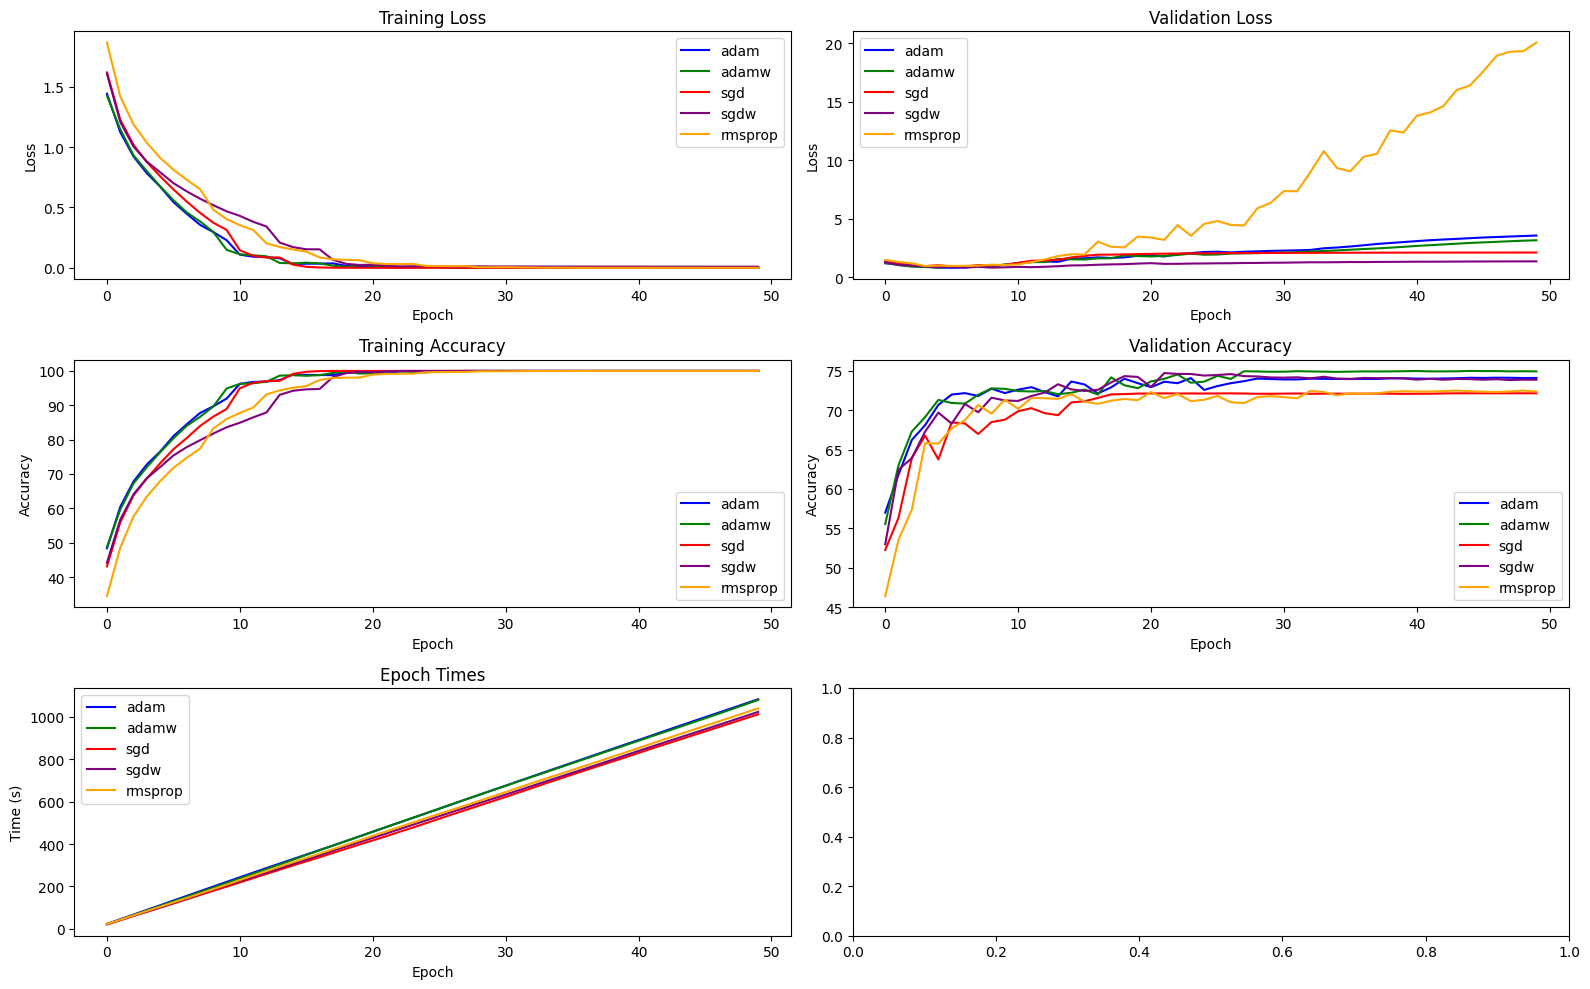

In [ ]:
train_and_evaluate(optimizers_params, model_class, loss_fn, trainer_class, device, trainloader, validationloader, testloader, num_classes, num_epochs)

### Custom

In [ ]:
model_class = ResNet
loss_fn = nn.CrossEntropyLoss()
trainer_class = CustomTrainer

In [ ]:
train_and_evaluate(optimizers_params, model_class, loss_fn, trainer_class, device, trainloader, validationloader, testloader, num_classes, num_epochs)

# Change & Revert

## Trainer

In [ ]:
class ChangeRevertTrainer:
    def __init__(
        self, device, trainloader, validationloader, testloader,
        main_model,
        main_loss,
        main_optimizer,
        num_epochs,
        early_stop_patience=5, early_stop_min_delta=0.001,
        check_early_stopping=False, to_plot_metrics=False
    ):
        self.device = device
        # data
        self.trainloader = trainloader
        self.validationloader = validationloader
        self.testloader = testloader
        # model
        self.main_model = main_model.to(device)
        # loss, optimizers
        self.main_criterion = main_loss
        self.main_optimizer = main_optimizer
        # training
        self.num_epochs = num_epochs
        # early stopping
        self.check_early_stopping = check_early_stopping
        self.best_loss = float("inf")
        self.early_stop_count = 0
        self.early_stop_patience = early_stop_patience
        self.early_stop_min_delta = early_stop_min_delta
        # metrics
        self.to_plot_metrics = to_plot_metrics
        self.training_losses = []
        self.training_accuracies = []
        self.validation_losses = []
        self.validation_accuracies = []
        self.epoch_times = []
        self.test_accuracy = 0

    def train(self):
        for epoch in range(self.num_epochs):
            start_time = time.time()
            running_loss = 0.0
            correct = 0
            total = 0
            # training
            self.main_model.train()
            for images, labels in self.trainloader:
                images, labels = images.to(self.device), labels.to(self.device)
                # step 1: store before-update states of the model
                original_state = copy.deepcopy(self.main_model.state_dict())
                # step 2: forward pass and loss computation for the main model
                outputs = self.main_model(images)
                loss = self.main_criterion(outputs, labels)
                # step 3: reset optimizers
                self.main_optimizer.optimizer.zero_grad()
                # step 4: compute gradients of main_model
                loss.backward()
                # step 5: update model parameters
                self.main_optimizer.optimizer.step()
                # step 6: compute step values
                new_state = self.main_model.state_dict()
                step_values = {}
                for name, param in self.main_model.named_parameters():
                    step_values[name] = new_state[name] - original_state[name]
                # step 7: revert parameter update
                for name, param in self.main_model.named_parameters():
                    param.data.copy_(original_state[name])
                # step 8: manually update the model parameters
                with torch.no_grad():
                    for name, param in self.main_model.named_parameters():
                        param.add_(step_values[name])
                # step 9: check that manually updated parameters are the same as in new_state
                all_match = True
                for name, param in self.main_model.named_parameters():
                    if not torch.allclose(param, new_state[name], atol=1e-6):
                        print(f"Mismatch found in parameter: {name}")
                        all_match = False
                if not all_match:
                    print("There were mismatches in parameter updates.")
                # step 10: track training loss and accuracy for the main_model
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            # calculate metrics for the epoch
            epoch_loss = running_loss / len(self.trainloader)
            epoch_accuracy = 100 * correct / total
            epoch_duration = time.time() - start_time
            self.training_losses.append(epoch_loss)
            self.training_accuracies.append(epoch_accuracy)
            self.epoch_times.append(epoch_duration)

            # validation
            val_running_loss, val_correct, val_total = 0.0, 0, 0
            self.main_model.eval()
            with torch.no_grad():
                for val_images, val_labels in self.validationloader:
                    val_images, val_labels = val_images.to(self.device), val_labels.to(self.device)
                    val_outputs = self.main_model(val_images)
                    val_loss = self.main_criterion(val_outputs, val_labels)
                    val_running_loss += val_loss.item()
                    _, val_predicted = val_outputs.max(1)
                    val_total += val_labels.size(0)
                    val_correct += val_predicted.eq(val_labels).sum().item()
            val_epoch_loss = val_running_loss / len(self.validationloader)
            val_epoch_accuracy = 100 * val_correct / val_total
            self.validation_losses.append(val_epoch_loss)
            self.validation_accuracies.append(val_epoch_accuracy)

            # plot metrics
            if self.to_plot_metrics:
                plot_metrics(self.epoch_times, self.training_losses, self.validation_losses, self.training_accuracies, self.validation_accuracies)
            # adjust schedulers
            self.main_optimizer.lr_scheduler.step(val_epoch_loss)
            # early stopping
            if self.check_early_stopping:
                if val_epoch_loss < self.best_loss - self.early_stop_min_delta:
                    self.best_loss = val_epoch_loss
                    self.early_stop_count = 0
                else:
                    self.early_stop_count += 1
                    if self.early_stop_count >= self.early_stop_patience:
                        print("Early stopping triggered.")
                        break

    def test(self):
        correct, total = 0, 0
        self.main_model.eval()
        with torch.no_grad():
            for images, labels in self.testloader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.main_model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        self.test_accuracy = 100 * correct / total
        print(f"Test Accuracy: {self.test_accuracy:.2f}%")

    def plot_metrics(self):
        clear_output(wait=True)
        plt.figure(figsize=(16, 10))
        cumulative_epoch_times = np.cumsum(self.epoch_times)
        metrics = [(self.training_losses, "Training Loss", "Loss"),
                   (self.validation_losses, "Validation Loss", "Loss"),
                   (self.training_accuracies, "Training Accuracy", "Accuracy"),
                   (self.validation_accuracies, "Validation Accuracy", "Accuracy"),
                   (cumulative_epoch_times, "Total Runtime", "Total Time (seconds)")]
        colors = ["b", "orange", "g", "purple", "r"]
        for i, (data, title, ylabel) in enumerate(metrics, 1):
            plt.subplot(3, 2, i)
            plt.plot(range(1, len(data) + 1), data, marker="o", linestyle="-", color=colors[i - 1])
            plt.title(title)
            plt.xlabel("Epoch")
            plt.ylabel(ylabel)
            plt.grid(True)
        plt.tight_layout()
        plt.show()

## Model, Loss & Optimizer Initialization

In [ ]:
main_model = ResNet(num_classes=10)
main_loss = nn.CrossEntropyLoss()
main_optimizer_params = {"optimizer_type": "adam", "lr": 0.001, "weight_decay": 0}
main_optimizer = Optimizer(model=main_model, optimizer_type=main_optimizer_params["optimizer_type"], lr=main_optimizer_params["lr"], weight_decay=main_optimizer_params["weight_decay"])

## Train

In [ ]:
cr_trainer = ChangeRevertTrainer(
    device, trainloader, validationloader, testloader,
    main_model,
    main_loss,
    main_optimizer,
    num_epochs, to_plot_metrics=True
)

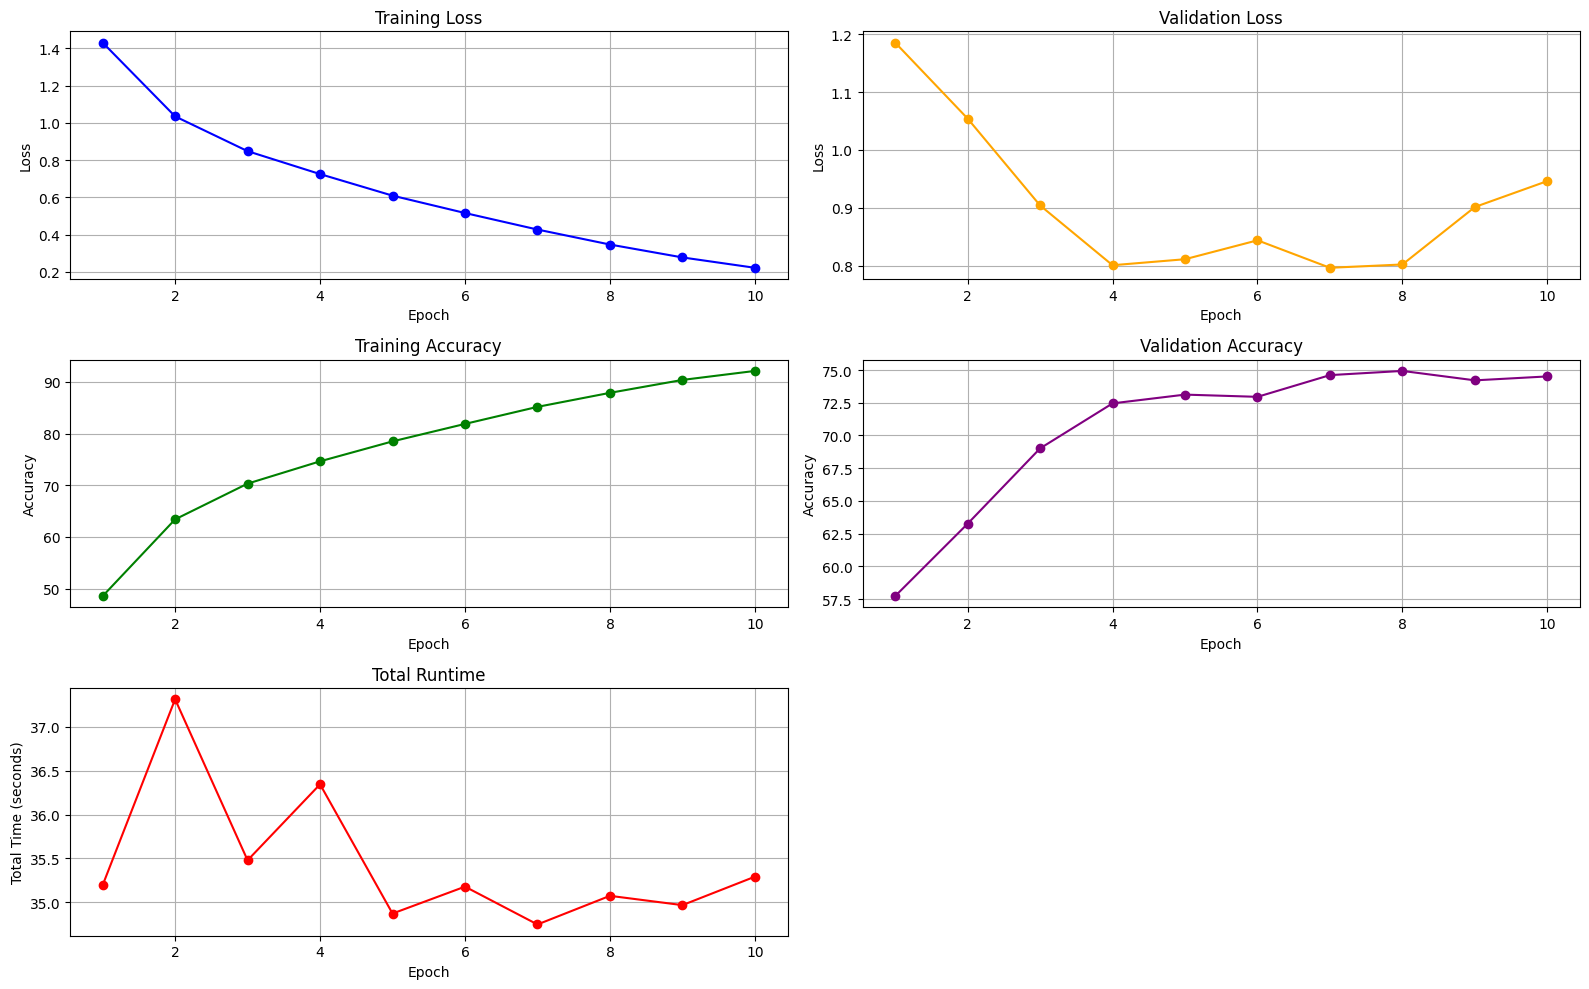

In [ ]:
cr_trainer.train()

# Aggregate

## Trainers

In [ ]:
class AvgTrainer:
    def __init__(
        self, device, trainloader, validationloader, testloader,
        main_model,
        main_loss,
        main_optimizers,
        num_epochs,
        early_stop_patience=5, early_stop_min_delta=0.001,
        check_early_stopping=False, to_plot_metrics=False
    ):
        self.device = device
        # data
        self.trainloader = trainloader
        self.validationloader = validationloader
        self.testloader = testloader
        # model
        self.main_model = main_model.to(device)
        # loss, optimizers
        self.main_criterion = main_loss
        self.main_optimizers = main_optimizers
        # training
        self.num_epochs = num_epochs
        # early stopping
        self.check_early_stopping = check_early_stopping
        self.best_loss = float("inf")
        self.early_stop_count = 0
        self.early_stop_patience = early_stop_patience
        self.early_stop_min_delta = early_stop_min_delta
        # metrics
        self.to_plot_metrics = to_plot_metrics
        self.training_losses = []
        self.training_accuracies = []
        self.validation_losses = []
        self.validation_accuracies = []
        self.epoch_times = []
        self.test_accuracy = 0

    def train(self):
        for epoch in range(self.num_epochs):
            start_time = time.time()
            running_loss = 0.0
            correct = 0
            total = 0
            # training
            self.main_model.train()
            for images, labels in self.trainloader:
                images, labels = images.to(self.device), labels.to(self.device)
                # step 1: store before-update states of the model
                original_state = copy.deepcopy(self.main_model.state_dict())
                # step 2: forward pass and loss computation for the main model
                outputs = self.main_model(images)
                loss = self.main_criterion(outputs, labels)
                # step 3: reset optimizers
                for main_optimizer in self.main_optimizers:
                    main_optimizer.optimizer.zero_grad()
                # step 4: compute gradients of main_model (same for each optimizer)
                loss.backward()
                # step 5: compute & store optimizer updated parameters
                main_optimizers_steps_values = []
                for optimizer_idx, main_optimizer in enumerate(self.main_optimizers):
                    # step 5.1: update model parameters
                    main_optimizer.optimizer.step()
                    # step 5.2: compute step values
                    new_state = self.main_model.state_dict()
                    step_values = {}
                    for name, param in self.main_model.named_parameters():
                        step_values[name] = new_state[name] - original_state[name]
                    # step 5.3: revert parameter update
                    for name, param in self.main_model.named_parameters():
                        param.data.copy_(original_state[name])
                    # step 5.4: store optimizer step values
                    main_optimizers_steps_values.append(step_values)
                # step 6: average optimizers steps
                averaged_steps = {}
                for name in main_optimizers_steps_values[0]:
                    averaged_steps[name] = sum(step_values[name] for step_values in main_optimizers_steps_values) / len(main_optimizers_steps_values)
                # step 7: manually update the model parameters with average optimizers steps
                with torch.no_grad():
                    for name, param in self.main_model.named_parameters():
                        param.add_(averaged_steps[name])
                # step 8: track training loss and accuracy for the main_model
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            # calculate metrics for the epoch
            epoch_loss = running_loss / len(self.trainloader)
            epoch_accuracy = 100 * correct / total
            epoch_duration = time.time() - start_time
            self.training_losses.append(epoch_loss)
            self.training_accuracies.append(epoch_accuracy)
            self.epoch_times.append(epoch_duration)

            # validation
            val_running_loss, val_correct, val_total = 0.0, 0, 0
            self.main_model.eval()
            with torch.no_grad():
                for val_images, val_labels in self.validationloader:
                    val_images, val_labels = val_images.to(self.device), val_labels.to(self.device)
                    val_outputs = self.main_model(val_images)
                    val_loss = self.main_criterion(val_outputs, val_labels)
                    val_running_loss += val_loss.item()
                    _, val_predicted = val_outputs.max(1)
                    val_total += val_labels.size(0)
                    val_correct += val_predicted.eq(val_labels).sum().item()
            val_epoch_loss = val_running_loss / len(self.validationloader)
            val_epoch_accuracy = 100 * val_correct / val_total
            self.validation_losses.append(val_epoch_loss)
            self.validation_accuracies.append(val_epoch_accuracy)

            # plot metrics
            if self.to_plot_metrics:
                plot_metrics(self.epoch_times, self.training_losses, self.validation_losses, self.training_accuracies, self.validation_accuracies)
            # adjust schedulers
            for optimizer in self.main_optimizers:
                optimizer.lr_scheduler.step(val_epoch_loss)
            # early stopping
            if self.check_early_stopping:
                if val_epoch_loss < self.best_loss - self.early_stop_min_delta:
                    self.best_loss = val_epoch_loss
                    self.early_stop_count = 0
                else:
                    self.early_stop_count += 1
                    if self.early_stop_count >= self.early_stop_patience:
                        print("Early stopping triggered.")
                        break

    def test(self):
        correct, total = 0, 0
        self.main_model.eval()
        with torch.no_grad():
            for images, labels in self.testloader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.main_model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        self.test_accuracy = 100 * correct / total
        print(f"Test Accuracy: {self.test_accuracy:.2f}%")

    def plot_metrics(self):
        clear_output(wait=True)
        plt.figure(figsize=(16, 10))
        metrics = [(self.training_losses, "Training Loss", "Loss"),
                   (self.validation_losses, "Validation Loss", "Loss"),
                   (self.training_accuracies, "Training Accuracy", "Accuracy"),
                   (self.validation_accuracies, "Validation Accuracy", "Accuracy"),
                   (self.epoch_times, "Total Runtime", "Total Time (seconds)")]
        colors = ["b", "orange", "g", "purple", "r"]
        for i, (data, title, ylabel) in enumerate(metrics, 1):
            plt.subplot(3, 2, i)
            plt.plot(range(1, len(data) + 1), data, marker="o", linestyle="-", color=colors[i - 1])
            plt.title(title)
            plt.xlabel("Epoch")
            plt.ylabel(ylabel)
            plt.grid(True)
        plt.tight_layout()
        plt.show()

## Model, Loss & Optimizers Initialization

In [ ]:
main_model = ResNet(num_classes=10)
main_loss = nn.CrossEntropyLoss()
main_optimizers_params = [
    {"optimizer_type": "adam", "lr": 0.001, "weight_decay": 0},
    {"optimizer_type": "adamw", "lr": 0.001, "weight_decay": 0.01},
    {"optimizer_type": "sgd", "lr": 0.01, "weight_decay": 0},
    {"optimizer_type": "sgdw", "lr": 0.01, "weight_decay": 0.01},
    {"optimizer_type": "rmsprop", "lr": 0.01, "weight_decay": 0}
]
main_optimizers = []
for optimizer_params in main_optimizers_params:
  main_optimizers.append(Optimizer(model=main_model, optimizer_type=optimizer_params["optimizer_type"], lr=optimizer_params["lr"], weight_decay=optimizer_params["weight_decay"]))

## Training

In [ ]:
avg_trainer = AvgTrainer(
    device, trainloader, validationloader, testloader,
    main_model,
    main_loss,
    main_optimizers,
    num_epochs, to_plot_metrics=True
)

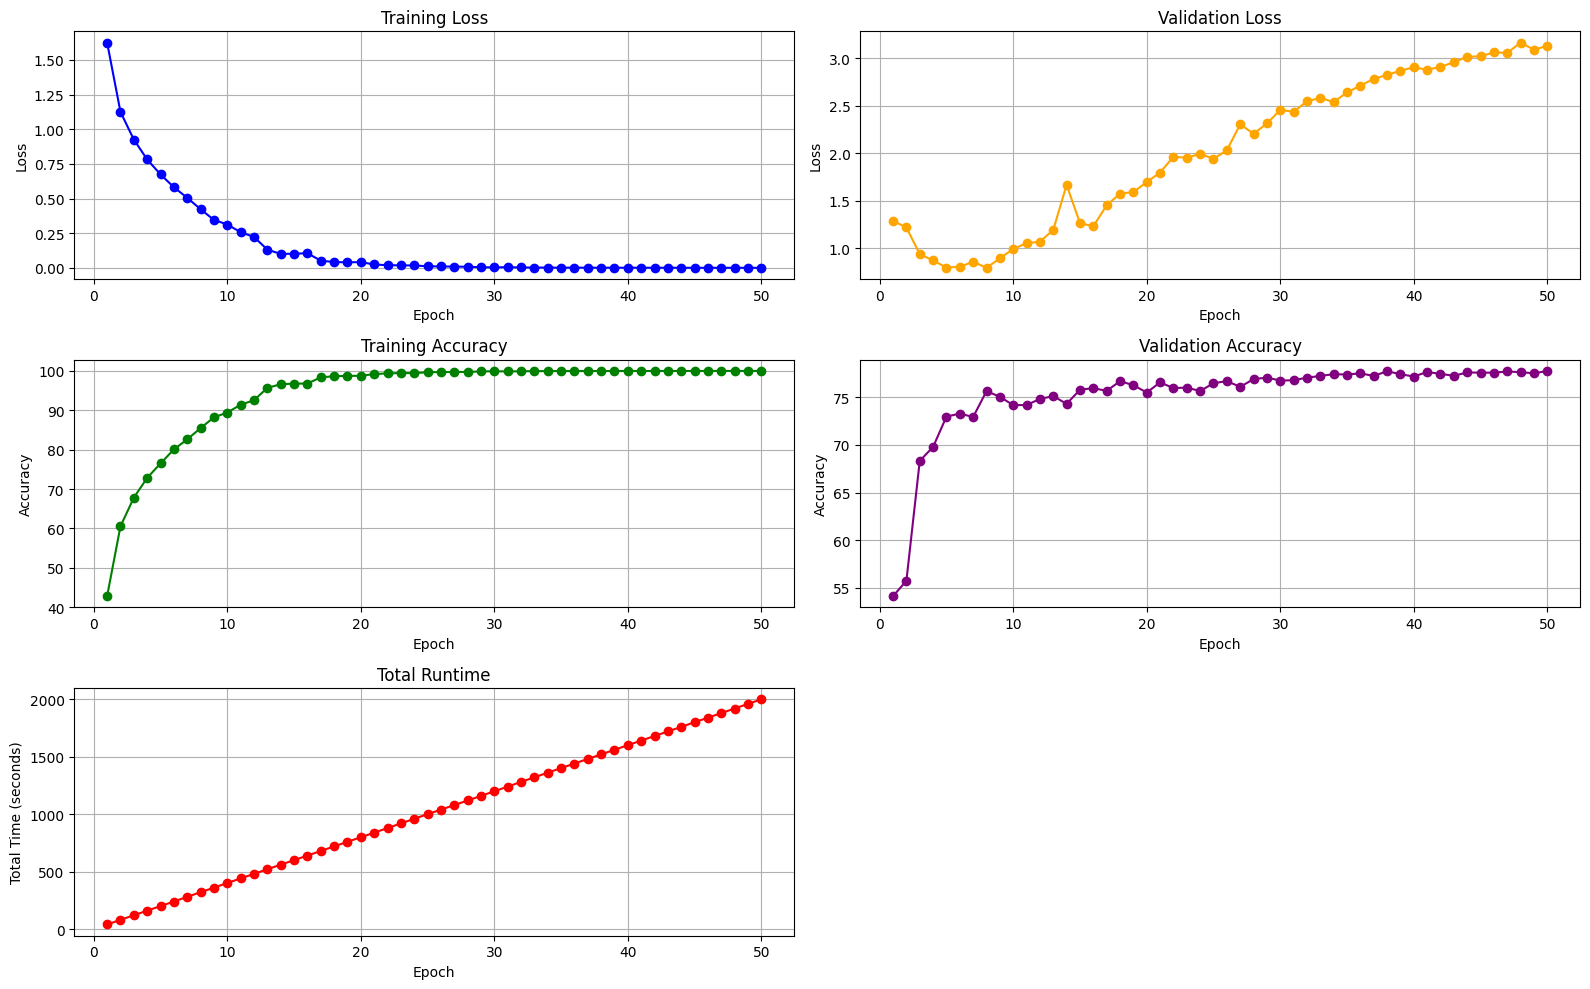

In [ ]:
avg_trainer.train()

# Meta

## Architectures

In [ ]:
class MetaLayerConv3d(nn.Module):
    """
    Process Conv2d weights (no biases).
    2*padding-dilation*(num_optimizers-1)=0
    """
    def __init__(self, num_optimizers, output_channels, input_channels, kernel_size, bias_neurons=64):
        super(MetaLayerConv3d, self).__init__()

        self.optimizers_padding_dilation_map = {
            2: [1, 2],
            3: [1, 1],
            4: [3, 2],
            5: [2, 1]
        }

        self.conv3d = nn.Conv3d(
            in_channels=num_optimizers,
            out_channels=1,
            kernel_size=(num_optimizers, 1, 1),
            stride=(1, 1, 1),
            padding=(self.optimizers_padding_dilation_map[num_optimizers][0], 0, 0),
            dilation=self.optimizers_padding_dilation_map[num_optimizers][1]
        )

        self.output_channels = output_channels
        self.input_channels = input_channels
        self.kernel_size = kernel_size

    def forward(self, weight_gradients):
        weight_gradients = input[0]
        # expect weight_gradients input of shape (num_optimizers, output_channels, input_channels, kernel_size, kernel_size)
        # add a batch dimension: shape becomes (1, num_optimizers, output_channels, input_channels, kernel_size, kernel_size)
        weight_gradients = weight_gradients.unsqueeze(0)
        # flatten last two dimensions to get shape (1, num_optimizers, output_channels, input_channels, kernel_size * kernel_size)
        weight_gradients = weight_gradients.view(1, weight_gradients.size(1), weight_gradients.size(2), weight_gradients.size(3), -1)
        # pass through Conv3d to combine optimizer channels, shape becomes (1, 1, output_channels, input_channels, kernel_size * kernel_size)
        conv_output = self.conv3d(weight_gradients)
        # remove batch dimension and channel
        weight_output = conv_output.squeeze(0).squeeze(0)
        # unflatten to (output_channels, input_channels, kernel_size, kernel_size)
        weight_output = weight_output.view(self.output_channels, self.input_channels, self.kernel_size, self.kernel_size)

        return [weight_output]

class MetaLayerConv2dConv1d(nn.Module):
    """
    Preprocesses FC weights and biases.
    """
    def __init__(self, num_optimizers, out_features, bias_neurons=64):
        super(MetaLayerConv2dConv1d, self).__init__()

        self.conv2d_weight = nn.Conv2d(in_channels=num_optimizers, out_channels=1, kernel_size=(1, 1), stride=1, padding=0)
        self.conv1d_bias = nn.Conv1d(in_channels=num_optimizers, out_channels=1, kernel_size=1)

    def forward(self, input):
        # expect a list containining weight_gradients and bias_gradients
        weight_gradients, bias_gradients = input[0], input[1]

        # --- Weights Gradients ---
        # expect weight_gradients input of shape (num_optimizers, in_features, out_features)
        # add a batch dimension: shape becomes (1, num_optimizers, in_features, out_features)
        weight_gradients = weight_gradients.unsqueeze(0)
        # pass through Conv2d to combine optimizer channels, shape becomes (1, 1, in_features, out_features)
        weight_gradients = self.conv2d_weight(weight_gradients)
        # remove batch dimension and channel
        weight_output = weight_gradients.squeeze(0).squeeze(0)

        # --- Bias Gradients ---
        # expect bias_gradients input of shape (num_optimizers, in_features)
        # add a batch dimension: shape becomes (1, num_optimizers, in_features)
        bias_gradients = bias_gradients.unsqueeze(0)
        # process through conv1d, shape becomes (1, 1, in_features)
        bias_output = self.conv1d_bias(bias_gradients)
        # remove batch dimension and channel
        bias_output = bias_output.squeeze(0).squeeze(0)

        return [weight_output, bias_output]

class MetaLayerConv1d(nn.Module):
    """
    Preprocess BN weights and biases.
    """
    def __init__(self, num_optimizers):
        super(MetaLayerConv1d, self).__init__()
        # using Conv1d to process weights and biases gradients independently
        self.conv1d_weight = nn.Conv1d(in_channels=num_optimizers, out_channels=1, kernel_size=1)
        self.conv1d_bias = nn.Conv1d(in_channels=num_optimizers, out_channels=1, kernel_size=1)

    def forward(self, input):
        # expect a list containining weight_gradients and bias_gradients
        weight_gradients, bias_gradients = input[0], input[1]
        # expect weight_gradients and bias_gradients input of shape (num_optimizers, out_channels)
        # add a batch dimension: shape becomes (1, num_optimizers, out_channels)
        weight_gradients = weight_gradients.unsqueeze(0)
        bias_gradients = bias_gradients.unsqueeze(0)
        # process each with Conv1d, shape becomes (1, 1, out_channels)
        weight_output = self.conv1d_weight(weight_gradients)
        bias_output = self.conv1d_bias(bias_gradients)
        # remove batch dimension and channel
        weight_output = weight_output.squeeze(0).squeeze(0)
        bias_output = bias_output.squeeze(0).squeeze(0)

        return [weight_output, bias_output]

class MetaNetwork(nn.Module):
    """
    A unified meta neural network that contains all necessary preprocessing modules for each layer in the main model.
    """
    def __init__(self):
        super(MetaNetwork, self).__init__()
        self.meta_layers = nn.ModuleList()

    def forward(self, inputs):
        meta_outputs = {}
        for meta_layer, (layer_idx, aggregated_layer_steps_dict) in zip(self.meta_layers, inputs.items()):
            inputs = []
            layer_names = []
            for layer_name, aggregated_layer_steps in aggregated_layer_steps_dict.items():
                inputs.append(aggregated_layer_steps)
                layer_names.append(layer_name)
            outputs = meta_layer(inputs)
            # check if tuple
            for layer_name, output in zip(layer_names, outputs):
                meta_outputs[layer_name] = output
        return meta_outputs

def initialize_meta_model(main_model, num_optimizers):
    meta_network = MetaNetwork()
    meta_layers_params_map = []
    param_idx = 0

    def process_layer(layer):
        nonlocal param_idx
        if isinstance(layer, nn.Conv2d):
            meta_layer = MetaLayerConv3d(
                num_optimizers=num_optimizers,
                output_channels=layer.out_channels,
                input_channels=layer.in_channels,
                kernel_size=layer.kernel_size[0]
            )
            meta_network.meta_layers.append(meta_layer)

            meta_layers_params_map.append({len(meta_network.meta_layers)-1: [param_idx]})
            param_idx += 1
        elif isinstance(layer, nn.Linear):
            meta_layer = MetaLayerConv2dConv1d(
                num_optimizers=num_optimizers,
                out_features=layer.out_features,
                bias_neurons=64
            )
            meta_network.meta_layers.append(meta_layer)

            meta_layers_params_map.append({len(meta_network.meta_layers)-1: [param_idx, param_idx + 1]})
            param_idx += 2
        elif isinstance(layer, nn.BatchNorm2d):
            meta_layer = MetaLayerConv1d(
                num_optimizers=num_optimizers
            )
            meta_network.meta_layers.append(meta_layer)

            meta_layers_params_map.append({len(meta_network.meta_layers)-1: [param_idx, param_idx + 1]})
            param_idx += 2
        elif isinstance(layer, nn.Sequential) or isinstance(layer, torchvision.models.resnet.BasicBlock):
            for sub_layer in layer.children():
                process_layer(sub_layer)

    # iterate over main_model.backbone layers
    for layer in main_model.backbone.children():
        process_layer(layer)

    return meta_network, meta_layers_params_map

def initialize_meta_layer_nns(main_model, num_optimizers):
    meta_layer_nns = []
    meta_layers_params_map = []

    def process_layer(layer):
        if isinstance(layer, nn.Conv2d):
            meta_layer = MetaLayerConv3d(
                num_optimizers=num_optimizers,
                output_channels=layer.out_channels,
                input_channels=layer.in_channels,
                kernel_size=layer.kernel_size[0]
            )
            meta_layer_nns.append(meta_layer)
        elif isinstance(layer, nn.Linear):
            meta_layer = MetaLayerConv2dConv1d(
                num_optimizers=num_optimizers,
                out_features=layer.out_features,
                bias_neurons=64
            )
            meta_layer_nns.append(meta_layer)
        elif isinstance(layer, nn.BatchNorm2d):
            meta_layer = MetaLayerConv1d(
                num_optimizers=num_optimizers
            )
            meta_layer_nns.append(meta_layer)
        elif isinstance(layer, nn.Sequential) or isinstance(layer, torchvision.models.resnet.BasicBlock):
            for sub_layer in layer.children():
                process_layer(sub_layer)

    # iterate over main_model.backbone layers
    for layer in main_model.backbone.children():
        process_layer(layer)

    param_idx = 0
    for idx, layer in enumerate(meta_layer_nns):
        if isinstance(layer, MetaLayerConv3d):
            # single param list
            meta_layers_params_map.append({idx: [param_idx]})
            param_idx += 1
        elif isinstance(layer, MetaLayerConv2dConv1d):
            # double param list
            meta_layers_params_map.append({idx: [param_idx, param_idx + 1]})
            param_idx += 2
        elif isinstance(layer, MetaLayerConv1d):
            # double param list
            meta_layers_params_map.append({idx: [param_idx, param_idx + 1]})
            param_idx += 2
    return nn.ModuleList(meta_layer_nns), meta_layers_params_map

## Testing Functions

In [ ]:
def count_meta_nns_main_params(main_model, meta_layer_nns):

    def count_model_params(model, model_name):
        table_data = []
        total_params = 0
        for name, param in model.named_parameters():
            if param.requires_grad:
                param_count = param.numel()
                total_params += param_count
                table_data.append({"Model": model_name, "Layer Name": name, "Number of Parameters": param_count})
        return table_data, total_params

    def count_meta_params(meta_layer_nns):
        table_data = []
        total_params = 0
        for i, meta_layer_nn in enumerate(meta_layer_nns):
            meta_table_data, meta_params_count = count_model_params(meta_layer_nn, model_name=f"Meta Layer NN {i+1}")
            table_data.extend(meta_table_data)
            total_params += meta_params_count
        return table_data, total_params

    main_table_data, main_total_params = count_model_params(main_model, "Main")
    meta_table_data, meta_total_params = count_meta_params(meta_layer_nns)

    table_data = main_table_data
    table_data.extend(meta_table_data)
    total_params = main_total_params + meta_total_params

    df = pd.DataFrame(table_data)
    main_total_row = pd.DataFrame([{"Model": "Main Model", "Layer Name": "-", "Number of Parameters": main_total_params}])
    meta_total_row = pd.DataFrame([{"Model": "Meta Layers", "Layer Name": "-", "Number of Parameters": meta_total_params}])
    total_row = pd.DataFrame([{"Model": "Main Model + Meta Layers", "Layer Name": "-", "Number of Parameters": total_params}])
    increase_percentage = int(((total_params / main_total_params) - 1) * 100)
    increase_row = pd.DataFrame([{"Model": "Overall Total / Main Total (%)", "Layer Name": "-", "Number of Parameters": increase_percentage}])
    summary_df = pd.concat([df, main_total_row, meta_total_row, total_row, increase_row], ignore_index=True)

    return summary_df

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def test_full_model_with_meta_layers(main_model, meta_layer_nns, meta_layer_params_map, num_optimizers=5):
    param_shapes = [param.shape for param in main_model.parameters()]
    random_inputs = []
    for param_map in meta_layer_params_map:
        for layer_idx, param_idxs in param_map.items():
            if len(param_idxs) == 2:
                # if two parameters (for batch norm weights and biases), create two inputs
                layer_params = []
                for param_idx in param_idxs:
                    original_shape = param_shapes[param_idx]
                    new_shape = (num_optimizers,) + original_shape
                    random_input = torch.randn(new_shape)
                    layer_params.append(random_input)
                # append both as a combined list for this layer
                random_inputs.append(layer_params)
            else:
                # for a single parameter (e.g., conv weight), create one input
                param_idx = param_idxs[0]
                original_shape = param_shapes[param_idx]
                new_shape = (num_optimizers,) + original_shape
                random_input = torch.randn(new_shape)
                random_inputs.append(random_input)
    processed_params = []
    for idx, random_input in enumerate(random_inputs):
        meta_layer = meta_layer_nns[idx]
        output = meta_layer(random_input)
        if len(output) == 2:
          processed_params.append(output[0])
          processed_params.append(output[1])
        else:
          processed_params.append(output)
    param_idx_tracker = set()  # to track if all indices are covered
    for idx, (original_param, processed_param) in enumerate(zip(main_model.parameters(), processed_params)):
        assert processed_param.shape == original_param.shape, \
            f"Shape mismatch at index {idx}: expected {original_param.shape}, got {processed_param.shape}"
        param_idx_tracker.add(idx)
    assert len(param_idx_tracker) == len(param_shapes), \
        f"Not all parameter indices are covered. Expected {len(param_shapes)}, got {len(param_idx_tracker)}"
    print("Full model meta-layer shape test passed.")
    return param_idx_tracker

## Models & Optimizers Initialization

In [ ]:
main_model = ResNet(num_classes=10)
main_optimizers_params = [
    {"optimizer_type": "adam", "lr": 0.001, "weight_decay": 0},
    {"optimizer_type": "adamw", "lr": 0.001, "weight_decay": 0.01},
    {"optimizer_type": "sgd", "lr": 0.01, "weight_decay": 0},
    {"optimizer_type": "sgdw", "lr": 0.01, "weight_decay": 0.01},
    {"optimizer_type": "rmsprop", "lr": 0.01, "weight_decay": 0}
]
main_optimizers = []
for optimizer_params in main_optimizers_params:
  main_optimizers.append(Optimizer(model=main_model, optimizer_type=optimizer_params["optimizer_type"], lr=optimizer_params["lr"], weight_decay=optimizer_params["weight_decay"]))

# meta_layer_nns, meta_layers_params_map = initialize_meta_layer_nns(main_model, len(main_optimizers))
meta_model, meta_layers_params_map = initialize_meta_model(main_model, len(main_optimizers))
meta_optimizer_params = {"optimizer_type": "adam", "lr": 0.001, "weight_decay": 0}
# meta_optimizer = MetaOptimizer(models=meta_layer_nns, optimizer_type=meta_optimizer_params["optimizer_type"], lr=meta_optimizer_params["lr"], weight_decay=meta_optimizer_params["weight_decay"])
meta_optimizer = MetaOptimizer(model=meta_model, optimizer_type=meta_optimizer_params["optimizer_type"], lr=meta_optimizer_params["lr"], weight_decay=meta_optimizer_params["weight_decay"])

In [ ]:
main_model_params = count_parameters(main_model)
print(f"Number of trainable parameters in main_model: {main_model_params}")
meta_network_params = count_parameters(meta_model)
print(f"Number of trainable parameters in meta_model: {meta_network_params}")
print(f"Number of layers in the meta_model: {len(meta_model.meta_layers)}")

Number of trainable parameters in main_model: 11181642
Number of trainable parameters in meta_model: 772
Number of layers in the meta_model: 41


In [ ]:
meta_layers_params_map

[{0: [0]},
 {1: [1, 2]},
 {2: [3]},
 {3: [4, 5]},
 {4: [6]},
 {5: [7, 8]},
 {6: [9]},
 {7: [10, 11]},
 {8: [12]},
 {9: [13, 14]},
 {10: [15]},
 {11: [16, 17]},
 {12: [18]},
 {13: [19, 20]},
 {14: [21]},
 {15: [22, 23]},
 {16: [24]},
 {17: [25, 26]},
 {18: [27]},
 {19: [28, 29]},
 {20: [30]},
 {21: [31, 32]},
 {22: [33]},
 {23: [34, 35]},
 {24: [36]},
 {25: [37, 38]},
 {26: [39]},
 {27: [40, 41]},
 {28: [42]},
 {29: [43, 44]},
 {30: [45]},
 {31: [46, 47]},
 {32: [48]},
 {33: [49, 50]},
 {34: [51]},
 {35: [52, 53]},
 {36: [54]},
 {37: [55, 56]},
 {38: [57]},
 {39: [58, 59]},
 {40: [60, 61]}]

## Meta Trainer

Chain of gradients to update the parameters of the meta layer models:

$$
\frac{\partial\text{Loss}}{\partial\theta_{\text{meta}}} = \frac{\partial\text{Loss}}{\partial\theta_{\text{main}}} \times \frac{\partial\theta_{\text{main}}}{\partial\theta_{\text{meta}}}
$$

### Meta-Layer NNs

#### All

In [ ]:
class MetaNNsTrainerAll:
    def __init__(
        self, device, trainloader, validationloader, testloader,
        main_model, meta_layer_nns, meta_layers_params_map,
        main_loss, meta_loss,
        main_optimizers, meta_optimizers,
        num_epochs,
        early_stop_patience=5, early_stop_min_delta=0.001,
        check_early_stopping=False, to_plot_metrics=False
    ):
        self.device = device
        # data
        self.trainloader = trainloader
        self.validationloader = validationloader
        self.testloader = testloader
        # models
        self.main_model = main_model.to(device)
        self.meta_layer_nns = meta_layer_nns
        for i, meta_layer_nn in enumerate(self.meta_layer_nns):
            self.meta_layer_nns[i] = meta_layer_nn.to(device)
        self.meta_layers_params_map = meta_layers_params_map
        # loss, optimizers, meta optimizers
        self.main_criterion = main_loss
        self.meta_criterion = meta_loss
        self.main_optimizers = main_optimizers
        self.meta_optimizers = meta_optimizers
        # training
        self.num_epochs = num_epochs
        # early stopping
        self.check_early_stopping = check_early_stopping
        self.best_loss = float("inf")
        self.early_stop_count = 0
        self.early_stop_patience = early_stop_patience
        self.early_stop_min_delta = early_stop_min_delta
        # metrics
        self.to_plot_metrics = to_plot_metrics
        self.training_losses = []
        self.training_accuracies = []
        self.validation_losses = []
        self.validation_accuracies = []
        self.epoch_times = []
        self.test_accuracy = 0

    def train(self):
        for epoch in range(self.num_epochs):
            start_time = time.time()
            running_loss = 0.0
            correct = 0
            total = 0
            # training
            self.main_model.train()
            for meta_layer_nn in self.meta_layer_nns:
                meta_layer_nn.train()
            for images, labels in self.trainloader:
                images, labels = images.to(self.device), labels.to(self.device)
                # step 1: store before-update states of the main model
                original_state = copy.deepcopy(self.main_model.state_dict())
                # step 2: forward pass and loss computation for the main model
                outputs = self.main_model(images)
                loss = self.main_criterion(outputs, labels)
                # step 3: reset optimizers
                for main_optimizer in self.main_optimizers:
                    main_optimizer.optimizer.zero_grad()
                # step 4: compute gradients of main_model (same for each optimizer)
                loss.backward()
                # step 5: compute & store optimizer updated parameters
                main_optimizers_steps_values = []
                for optimizer_idx, main_optimizer in enumerate(self.main_optimizers):
                    # step 5.1: update model parameters
                    main_optimizer.optimizer.step()
                    # step 5.2: compute step values
                    new_state = self.main_model.state_dict()
                    step_values = {}
                    for name, param in self.main_model.named_parameters():
                        step_values[name] = new_state[name] - original_state[name]
                    # step 5.3: revert parameter update
                    for name, param in self.main_model.named_parameters():
                        param.data.copy_(original_state[name])
                    # step 5.4: store optimizer step values
                    main_optimizers_steps_values.append(step_values)
                # step 6: pass each layer's parameter updates through its meta-layer NN
                meta_outputs = {}
                param_idx = 0
                param_names = list(main_optimizers_steps_values[0].keys())
                for layer_param_map in self.meta_layers_params_map: # e.g. {1: [1,2]}
                    for meta_layer_idx, main_param_idxs in layer_param_map.items():
                        meta_layer_nn = self.meta_layer_nns[meta_layer_idx] # meta_layer_nn
                        # step 6.1: finding weight and bias values from main_optimizers_steps_values
                        weight_param_name = param_names[main_param_idxs[0]]
                        bias_param_name = param_names[main_param_idxs[1]] if len(main_param_idxs) > 1 else None
                        if bias_param_name:
                            weights_list = [
                                main_optimizers_steps_values[optimizer_idx][weight_param_name]
                                for optimizer_idx in range(len(self.main_optimizers))]
                            biases_list = [
                                main_optimizers_steps_values[optimizer_idx][bias_param_name]
                                for optimizer_idx in range(len(self.main_optimizers))]
                            # main_optimizers_step_values will be a list of two tensors: [weights_tensor, biases_tensor]
                            main_optimizers_step_values = [
                                torch.stack(weights_list),
                                torch.stack(biases_list)]
                        else:
                            weights_list = [
                                main_optimizers_steps_values[optimizer_idx][weight_param_name]
                                for optimizer_idx in range(len(self.main_optimizers))]
                            # main_optimizers_step_values will be a single tensor with shape (num_optimizers, weights_shape)
                            main_optimizers_step_values = torch.stack(weights_list)
                        # step 6.2: pass the collected parameters to the meta-layer NN
                        meta_output = meta_layer_nn(main_optimizers_step_values)
                        # step 6.3 unpack and store the output from the meta-layer
                        if isinstance(meta_output, tuple):
                            meta_outputs[weight_param_name] = meta_output[0]
                            meta_outputs[bias_param_name] = meta_output[1]
                        else:
                            meta_outputs[weight_param_name] = meta_output
                # step 7: store the updated main model's parameters using the meta-layer NNs outputs
                updated_meta_params = {}
                for name, param in self.main_model.named_parameters():
                    meta_output = meta_outputs[name].to(self.device)
                    updated_param = param + meta_output
                    updated_meta_params[name] = updated_param
                    if not updated_meta_params[name].requires_grad:
                        updated_meta_params[name].requires_grad = True
                # step 8: perform forward pass for meta neural networks with updated parameters
                outputs_updated = functional_call(self.main_model, updated_meta_params, (images,))
                # step 9: compute the meta loss
                meta_loss = self.meta_criterion(outputs_updated, labels)
                # step 10: zero out gradients, backpropagate, and update meta neural networks
                for meta_optimizer in self.meta_optimizers:
                    meta_optimizer.optimizer.zero_grad()
                meta_loss.backward()
                for meta_optimizer in self.meta_optimizers:
                    meta_optimizer.optimizer.step()
                # step 11: update main_model with meta-learned parameters
                with torch.no_grad():
                    for name, param in self.main_model.named_parameters():
                        param.copy_(updated_meta_params[name])
                # step 12: check that gradients flow to meta_layer_nns
                for meta_nn in self.meta_layer_nns:
                    for param in meta_nn.parameters():
                        if param.grad is None:
                            print("No gradient for a parameter in meta neural network.")
                # step 13: check that main_model parameters are actually updated with meta learned parameters
                for name, param in self.main_model.named_parameters():
                    if torch.equal(param.data, original_state[name]):
                        print(f"Parameter {name} has not been updated.")
                # step 14: track training loss and accuracy for the main model
                running_loss += meta_loss.item()
                _, predicted = outputs_updated.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            # calculate metrics for the epoch
            epoch_loss = running_loss / len(self.trainloader)
            epoch_accuracy = 100 * correct / total
            epoch_duration = time.time() - start_time
            self.training_losses.append(epoch_loss)
            self.training_accuracies.append(epoch_accuracy)
            self.epoch_times.append(epoch_duration)

            # validation
            val_running_loss, val_correct, val_total = 0.0, 0, 0
            self.main_model.eval()
            with torch.no_grad():
                for val_images, val_labels in self.validationloader:
                    val_images, val_labels = val_images.to(self.device), val_labels.to(self.device)
                    val_outputs = self.main_model(val_images)
                    val_loss = self.main_criterion(val_outputs, val_labels)
                    val_running_loss += val_loss.item()
                    _, val_predicted = val_outputs.max(1)
                    val_total += val_labels.size(0)
                    val_correct += val_predicted.eq(val_labels).sum().item()
            val_epoch_loss = val_running_loss / len(self.validationloader)
            val_epoch_accuracy = 100 * val_correct / val_total
            self.validation_losses.append(val_epoch_loss)
            self.validation_accuracies.append(val_epoch_accuracy)

            # plot metrics
            if self.to_plot_metrics:
                plot_metrics(self.epoch_times, self.training_losses, self.validation_losses, self.training_accuracies, self.validation_accuracies)
            # adjust schedulers
            # main_model optimizers
            for optimizer in self.main_optimizers:
                optimizer.lr_scheduler.step(val_epoch_loss)
            # meta_layer_nns optimizers
            for optimizer in self.meta_optimizers:
                optimizer.lr_scheduler.step(val_epoch_loss)
            # early stopping
            if self.check_early_stopping:
                if val_epoch_loss < self.best_loss - self.early_stop_min_delta:
                    self.best_loss = val_epoch_loss
                    self.early_stop_count = 0
                else:
                    self.early_stop_count += 1
                    if self.early_stop_count >= self.early_stop_patience:
                        print("Early stopping triggered.")
                        break

    def test(self):
        correct, total = 0, 0
        self.main_model.eval()
        with torch.no_grad():
            for images, labels in self.testloader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.main_model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        self.test_accuracy = 100 * correct / total
        print(f"Test Accuracy: {self.test_accuracy:.2f}%")

#### Individual

In [ ]:
class MetaNNsTrainerIndividual:
    def __init__(
        self, device, trainloader, validationloader, testloader,
        main_model, meta_layer_nns, meta_layers_params_map,
        loss_fn,
        main_optimizers, meta_optimizer,
        num_epochs,
        early_stop_patience=5, early_stop_min_delta=0.001,
        check_early_stopping=False, to_plot_metrics=False
    ):
        self.device = device
        # data
        self.trainloader = trainloader
        self.validationloader = validationloader
        self.testloader = testloader
        # models
        self.main_model = main_model.to(device)
        self.meta_layer_nns = meta_layer_nns
        for i, meta_layer_nn in enumerate(self.meta_layer_nns):
            self.meta_layer_nns[i] = meta_layer_nn.to(device)
        self.meta_layers_params_map = meta_layers_params_map
        # loss, optimizers, meta optimizers
        self.criterion = loss_fn
        self.main_optimizers = main_optimizers
        self.meta_optimizer = meta_optimizer
        # training
        self.num_epochs = num_epochs
        # early stopping
        self.check_early_stopping = check_early_stopping
        self.best_loss = float("inf")
        self.early_stop_count = 0
        self.early_stop_patience = early_stop_patience
        self.early_stop_min_delta = early_stop_min_delta
        # metrics
        self.to_plot_metrics = to_plot_metrics
        self.training_losses = []
        self.training_accuracies = []
        self.validation_losses = []
        self.validation_accuracies = []
        self.epoch_times = []
        self.test_accuracy = 0

    def train(self):
        for epoch in range(self.num_epochs):
            start_time = time.time()
            running_loss = 0.0
            correct = 0
            total = 0
            # training
            self.main_model.train()
            for meta_layer_nn in self.meta_layer_nns:
                meta_layer_nn.train()
            for images, labels in self.trainloader:
                images, labels = images.to(self.device), labels.to(self.device)
                # step 1: store before-update states of the main model
                original_state = copy.deepcopy(self.main_model.state_dict())
                # step 2: forward pass and loss computation for the main model
                outputs = self.main_model(images)
                loss = self.criterion(outputs, labels)
                # step 3: reset optimizers
                for main_optimizer in self.main_optimizers:
                    main_optimizer.optimizer.zero_grad()
                # step 4: compute gradients of main_model (same for each optimizer)
                loss.backward()
                # step 5: compute & store optimizer updated parameters
                main_optimizers_steps_values = []
                for optimizer_idx, main_optimizer in enumerate(self.main_optimizers):
                    # step 5.1: update model parameters
                    main_optimizer.optimizer.step()
                    # step 5.2: compute step values
                    new_state = self.main_model.state_dict()
                    step_values = {}
                    for name, param in self.main_model.named_parameters():
                        step_values[name] = new_state[name] - original_state[name]
                    # step 5.3: revert parameter update
                    for name, param in self.main_model.named_parameters():
                        param.data.copy_(original_state[name])
                    # step 5.4: store optimizer step values
                    main_optimizers_steps_values.append(step_values)
                # step 6: meta-nn-layer training
                meta_nns_loss = 0.0
                meta_outputs = {}
                param_names = list(main_optimizers_steps_values[0].keys())
                main_params = {name: param.clone() for name, param in self.main_model.named_parameters()}
                for layer_param_map in self.meta_layers_params_map: # e.g. {1: [1,2]}
                    for meta_layer_idx, main_param_idxs in layer_param_map.items():
                        meta_layer_nn = self.meta_layer_nns[meta_layer_idx] # meta_layer_nn
                        # step 6.1: finding weight and bias values from main_optimizers_steps_values
                        weight_param_name = param_names[main_param_idxs[0]]
                        bias_param_name = param_names[main_param_idxs[1]] if len(main_param_idxs) > 1 else None
                        if bias_param_name:
                            weights_list = [
                                main_optimizers_steps_values[optimizer_idx][weight_param_name]
                                for optimizer_idx in range(len(self.main_optimizers))]
                            biases_list = [
                                main_optimizers_steps_values[optimizer_idx][bias_param_name]
                                for optimizer_idx in range(len(self.main_optimizers))]
                            # main_optimizers_step_values will be a list of two tensors: [weights_tensor, biases_tensor]
                            main_optimizers_step_values = [
                                torch.stack(weights_list),
                                torch.stack(biases_list)]
                        else:
                            weights_list = [
                                main_optimizers_steps_values[optimizer_idx][weight_param_name]
                                for optimizer_idx in range(len(self.main_optimizers))]
                            # main_optimizers_step_values will be a single tensor with shape (num_optimizers, weights_shape)
                            main_optimizers_step_values = torch.stack(weights_list)
                        # step 6.2: pass the collected parameters to the meta-layer NN
                        meta_output = meta_layer_nn(main_optimizers_step_values)
                        # step 6.3 unpack and store the output from the meta-layer
                        if isinstance(meta_output, tuple):
                            meta_outputs[weight_param_name] = meta_output[0]
                            meta_outputs[bias_param_name] = meta_output[1]
                        else:
                            meta_outputs[weight_param_name] = meta_output
                        # step 6.4: update main_model's parameters with meta_output
                        main_params[weight_param_name] = main_params[weight_param_name] + meta_outputs[weight_param_name]
                        if bias_param_name:
                            main_params[bias_param_name] = main_params[bias_param_name] + meta_outputs[bias_param_name]
                        # step 6.5: forward pass with updated parameters
                        outputs_updated = functional_call(self.main_model, main_params, (images,))
                        # step 6.6: compute meta loss for this meta_layer_nn
                        meta_loss = self.criterion(outputs_updated, labels)
                        # step 6.7: accumulate meta loss
                        meta_nns_loss += meta_loss
                        # Step 6.8: revert main_model parameters (only the updated parameters)
                        with torch.no_grad():
                            main_params[weight_param_name] = original_state[weight_param_name]
                            if bias_param_name:
                                main_params[bias_param_name] = original_state[bias_param_name]
                # step 7: update main_model weights with all meta_outputs
                with torch.no_grad():
                    for name, param in self.main_model.named_parameters():
                        param.add_(meta_outputs[name])
                # step 8: backpropagate accumulated meta_loss and update meta_layer_nns
                self.meta_optimizer.optimizer.zero_grad()
                meta_nns_loss.backward()
                self.meta_optimizer.optimizer.step()
                # step 9: verification
                for name, param in self.main_model.named_parameters():
                    if torch.equal(param.data, original_state[name]):
                        print(f"Parameter {name} has not been updated.")
                    if not torch.equal(param.data, original_state[name] + meta_outputs[name]):
                        print(f"Parameter {name} does not equal to original_state + meta_outputs.")
                for meta_nn in self.meta_layer_nns:
                    for param in meta_nn.parameters():
                        if param.grad is None:
                            print("No gradient for a parameter in meta neural network.")
                # step 10: tracking training perfomance of main_model
                running_loss += loss.item()  # from step 2
                _, predicted = outputs.max(1)  # from step 2
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            # calculate metrics for the epoch
            epoch_loss = running_loss / len(self.trainloader)
            epoch_accuracy = 100 * correct / total
            epoch_duration = time.time() - start_time
            self.training_losses.append(epoch_loss)
            self.training_accuracies.append(epoch_accuracy)
            self.epoch_times.append(epoch_duration)

            # validation
            val_running_loss, val_correct, val_total = 0.0, 0, 0
            self.main_model.eval()
            with torch.no_grad():
                for val_images, val_labels in self.validationloader:
                    val_images, val_labels = val_images.to(self.device), val_labels.to(self.device)
                    val_outputs = self.main_model(val_images)
                    val_loss = self.criterion(val_outputs, val_labels)
                    val_running_loss += val_loss.item()
                    _, val_predicted = val_outputs.max(1)
                    val_total += val_labels.size(0)
                    val_correct += val_predicted.eq(val_labels).sum().item()
            val_epoch_loss = val_running_loss / len(self.validationloader)
            val_epoch_accuracy = 100 * val_correct / val_total
            self.validation_losses.append(val_epoch_loss)
            self.validation_accuracies.append(val_epoch_accuracy)

            # plot metrics
            if self.to_plot_metrics:
                plot_metrics(self.epoch_times, self.training_losses, self.validation_losses, self.training_accuracies, self.validation_accuracies)
            # adjust schedulers
            # main_model optimizers
            for optimizer in self.main_optimizers:
                optimizer.lr_scheduler.step(val_epoch_loss)
            # meta_layer_nns optimizer
            meta_optimizer.lr_scheduler.step(val_epoch_loss)
            # early stopping
            if self.check_early_stopping:
                if val_epoch_loss < self.best_loss - self.early_stop_min_delta:
                    self.best_loss = val_epoch_loss
                    self.early_stop_count = 0
                else:
                    self.early_stop_count += 1
                    if self.early_stop_count >= self.early_stop_patience:
                        print("Early stopping triggered.")
                        break

    def test(self):
        correct, total = 0, 0
        self.main_model.eval()
        with torch.no_grad():
            for images, labels in self.testloader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.main_model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        self.test_accuracy = 100 * correct / total
        print(f"Test Accuracy: {self.test_accuracy:.2f}%")

### Meta NN

In [ ]:
class MetaNNTrainer:
    def __init__(
        self, device, trainloader, validationloader, testloader,
        main_model, meta_model, meta_layers_params_map,
        loss_fn,
        main_optimizers, meta_optimizer,
        num_epochs,
        early_stop_patience=5, early_stop_min_delta=0.001,
        check_early_stopping=False, to_plot_metrics=False
    ):
        self.device = device
        # data
        self.trainloader = trainloader
        self.validationloader = validationloader
        self.testloader = testloader
        # models
        self.main_model = main_model.to(device)
        self.meta_model = meta_model.to(device)
        self.meta_layers_params_map = meta_layers_params_map
        # loss, optimizers, meta optimizers
        self.criterion = loss_fn
        self.main_optimizers = main_optimizers
        self.meta_optimizer = meta_optimizer
        # training
        self.num_epochs = num_epochs
        # early stopping
        self.check_early_stopping = check_early_stopping
        self.best_loss = float("inf")
        self.early_stop_count = 0
        self.early_stop_patience = early_stop_patience
        self.early_stop_min_delta = early_stop_min_delta
        # metrics
        self.to_plot_metrics = to_plot_metrics
        self.training_losses = []
        self.training_accuracies = []
        self.validation_losses = []
        self.validation_accuracies = []
        self.epoch_times = []
        self.test_accuracy = 0

    def train(self):
        for epoch in range(self.num_epochs):
            start_time = time.time()
            running_loss = 0.0
            correct = 0
            total = 0
            # training
            self.main_model.train()
            self.meta_model.train()
            for images, labels in self.trainloader:
                images, labels = images.to(self.device), labels.to(self.device)
                # step 1: store before-update states of the main model
                original_state = copy.deepcopy(self.main_model.state_dict())
                # step 2: forward pass
                outputs = self.main_model(images)
                # step 3: loss
                loss = self.criterion(outputs, labels)
                # step 4: reset optimizers
                for main_optimizer in self.main_optimizers:
                    main_optimizer.optimizer.zero_grad()
                # step 5: compute gradients of main_model (same for each optimizer)
                loss.backward()
                # step 6: compute & store optimizer updated parameters
                main_optimizers_steps_values = []
                for optimizer_idx, main_optimizer in enumerate(self.main_optimizers):
                    # step 6.1: update model parameters
                    main_optimizer.optimizer.step()
                    # step 6.2: compute step values
                    new_state = self.main_model.state_dict()
                    step_values = {}
                    for name, param in self.main_model.named_parameters():
                        step_values[name] = new_state[name] - original_state[name]
                    # step 6.3: revert parameter update
                    for name, param in self.main_model.named_parameters():
                        param.data.copy_(original_state[name])
                    # step 6.4: store optimizer step values
                    main_optimizers_steps_values.append(step_values)
                # step 7: meta-nn-layer training
                main_param_names = list(main_optimizers_steps_values[0].keys())
                aggregated_step_values = {}
                for layer_param_map in self.meta_layers_params_map: # e.g. {1: [1,2]}'
                    agg_dict = {}
                    for meta_layer_idx, main_param_idxs in layer_param_map.items():
                        # find weight and bias values from main_optimizers_steps_values
                        weight_param_name = main_param_names[main_param_idxs[0]]
                        bias_param_name = main_param_names[main_param_idxs[1]] if len(main_param_idxs) > 1 else None
                        # collect weight and bias (if available) step values across all optimizers
                        weights_list = [
                            main_optimizers_steps_values[optimizer_idx][weight_param_name]
                            for optimizer_idx in range(len(self.main_optimizers))
                        ]
                        # stack step values: shape (num_optimizers, ...)
                        agg_dict[weight_param_name] = torch.stack(weights_list)
                        if bias_param_name:
                            biases_list = [
                                main_optimizers_steps_values[optimizer_idx][bias_param_name]
                                for optimizer_idx in range(len(self.main_optimizers))
                            ]
                            # stack step values: shape (num_optimizers, ...)
                            agg_dict[bias_param_name] = torch.stack(biases_list)
                        aggregated_step_values[meta_layer_idx] = agg_dict
                # step 8: forward pass for meta_model
                meta_outputs = self.meta_model(aggregated_step_values)
                # step 9: prepare updated parameters using meta_outputs
                updated_main_params = {}
                for name, param in self.main_model.named_parameters():
                    if name in meta_outputs:
                        updated_main_params[name] = param + meta_outputs[name]
                    else:
                        updated_main_params[name] = param
                # step 10: forward pass with updated parameters using functional_call
                outputs_updated = functional_call(self.main_model, updated_main_params, (images,))
                # step 11: meta loss
                meta_loss = self.criterion(outputs_updated, labels)
                # step 12: reset meta_optimizer
                self.meta_optimizer.optimizer.zero_grad()
                # step 13: meta backward pass
                meta_loss.backward()
                # step 14: meta optimizer step
                self.meta_optimizer.optimizer.step()
                # step 15: update main_model's parameters with meta_outputs within torch.no_grad()
                with torch.no_grad():
                    for name, param in self.main_model.named_parameters():
                        if name in meta_outputs:
                            param.add_(meta_outputs[name])
                # step 16: verification
                for name, param in self.main_model.named_parameters():
                    if torch.equal(param.data, original_state[name]):
                        print(f"Parameter {name} has not been updated.")
                    if not torch.equal(param.data, original_state[name] + meta_outputs[name]):
                        print(f"Parameter {name} does not equal to original_state + meta_outputs.")
                for param in self.meta_model.parameters():
                    if param.grad is None:
                        print("No gradient for a parameter in the meta neural network.")
                # step 17: tracking training perfomance of main_model
                running_loss += meta_loss.item()
                _, predicted = outputs_updated.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            # calculate metrics for the epoch
            epoch_loss = running_loss / len(self.trainloader)
            epoch_accuracy = 100 * correct / total
            epoch_duration = time.time() - start_time
            self.training_losses.append(epoch_loss)
            self.training_accuracies.append(epoch_accuracy)
            self.epoch_times.append(epoch_duration)

            # validation
            val_running_loss, val_correct, val_total = 0.0, 0, 0
            self.main_model.eval()
            with torch.no_grad():
                for val_images, val_labels in self.validationloader:
                    val_images, val_labels = val_images.to(self.device), val_labels.to(self.device)
                    val_outputs = self.main_model(val_images)
                    val_loss = self.criterion(val_outputs, val_labels)
                    val_running_loss += val_loss.item()
                    _, val_predicted = val_outputs.max(1)
                    val_total += val_labels.size(0)
                    val_correct += val_predicted.eq(val_labels).sum().item()
            val_epoch_loss = val_running_loss / len(self.validationloader)
            val_epoch_accuracy = 100 * val_correct / val_total
            self.validation_losses.append(val_epoch_loss)
            self.validation_accuracies.append(val_epoch_accuracy)

            # plot metrics
            if self.to_plot_metrics:
                plot_metrics(self.epoch_times, self.training_losses, self.validation_losses, self.training_accuracies, self.validation_accuracies)
            # adjust schedulers
            # main_model optimizers
            for optimizer in self.main_optimizers:
                optimizer.lr_scheduler.step(val_epoch_loss)
            # meta_model optimizer
            meta_optimizer.lr_scheduler.step(val_epoch_loss)
            # early stopping
            if self.check_early_stopping:
                if val_epoch_loss < self.best_loss - self.early_stop_min_delta:
                    self.best_loss = val_epoch_loss
                    self.early_stop_count = 0
                else:
                    self.early_stop_count += 1
                    if self.early_stop_count >= self.early_stop_patience:
                        print("Early stopping triggered.")
                        break

    def test(self):
        correct, total = 0, 0
        self.main_model.eval()
        with torch.no_grad():
            for images, labels in self.testloader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.main_model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        self.test_accuracy = 100 * correct / total
        print(f"Test Accuracy: {self.test_accuracy:.2f}%")

## Training

In [ ]:
loss_fn = nn.CrossEntropyLoss()

meta_trainer = MetaNNTrainer(
    device, trainloader, validationloader, testloader,
    main_model, meta_model, meta_layers_params_map,
    loss_fn, main_optimizers, meta_optimizer,
    num_epochs, to_plot_metrics=True
)

In [ ]:
 meta_trainer.train()

RuntimeError: Given groups=1, weight of size [1, 5, 1], expected input[1, 1, 64] to have 5 channels, but got 1 channels instead